# Exercise 1

In this exercise we are going to learn in practice how Linear Regression works.

Before running the code, please refer to [this link](https://pytorch.org/get-started/locally/) to install PyTorch using the appropriate command for your system.

You also need to install the `matplotlib` library using the following command:

```bash
pip install matplotlib
```

In [2]:
import torch

torch.manual_seed(42)

# Set the device to be used for training. If a GPU is available, use it. Otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Plotting Utils

Plotting is quite important in machine learning which helps us quickly get intuition from enormous data points and gain intuition. Plus they also do good to your illustration. Matplotlib is one of the most commonly used plotting libraries in python. 

Seaborn, Nineplot and Plotly are also powerful and it's important to master at least one of them. 

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc

## Creating Toy Data

We have prepared the toy data for you. But do not just skip this part! Skim through it and think:

- Why are we declaring a known function and add random noise to samples from it? What are the practical counterparts of them?

- Why do we choose Gaussian distribution as the noise instead of the other distributions?

In [4]:
def func(x):
    return 2 * x + 1

def create_toy_data(func, interval, sample_num, noise = 0.0, add_outlier = False, outlier_ratio = 0.001):
    """
    generate data with the given function
    
    input:
       - func: the input function
       - interval: the range of values of x, a tuple (start, end)
       - sample_num: number of samples
       - noise: the standard deviation of Gaussian noise
       - add_outlier: whether to generate outliers
       - outlier_ratio: proportion of outliers
       
    output:
       - X: samples, shape = [n_samples,1]
       - y: labels, shape = [n_samples,1]
    """
    
    X = torch.rand(sample_num,1, device=device) * (interval[1]-interval[0]) + interval[0]
    y = func(X)

    # add Gaussian noise
    epsilon = torch.normal(0, noise, (sample_num,1), device=device)
    y = y + epsilon
    
    # add outlier
    if add_outlier:
        outlier_num = int(sample_num * outlier_ratio)
        if outlier_num != 0:
            outlier_idx = torch.randint(sample_num, size = [outlier_num,1], device=device)
            y[outlier_idx] = y[outlier_idx] * 5
            
    return X, y

The black line in the following figure stands for the underlying data distribution, circles for trainig data and triangles for test data.

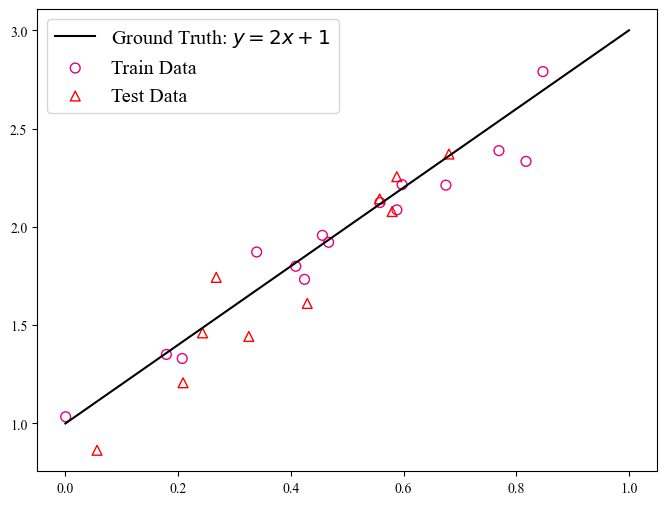

In [5]:
interval = (0,1)
train_num = 15
test_num = 10
noise = 0.2
X_train, y_train = create_toy_data(func=func, interval=interval, sample_num=train_num, noise=noise)
X_test, y_test = create_toy_data(func=func, interval=interval, sample_num=test_num, noise=noise)

X_underlying = torch.linspace(interval[0],interval[1],100, device=device)
y_underlying = func(X_underlying)

# plot
"""_summary_ draw the plot of the underlying function and the training and test data"""
rc('font', family='times new roman')
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.plot(X_underlying.cpu(), y_underlying.cpu(), c='#000000', label=r"Ground Truth: $y = 2x + 1$")
plt.scatter(X_train.cpu(), y_train.cpu(), facecolor="none", edgecolor='#e4007f', s=50, label="Train Data")
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker = '^', s=50, label="Test Data")
plt.legend(fontsize='x-large')
plt.show()

## Using PyTorch for Linear Regression

PyTorch is a powerful deep learning framework which is widely used in academia and industry. It is also a good tool for learning machine learning. In this exercise, we are going to use PyTorch to implement a simple linear regression model.

We are going to use two methods to implement the linear regression model. The first one is to use the closed-form solution, and the second one is to use the gradient descent algorithm.

## Closed-form Solution without Bias

Here we present an example of using the closed-form solution to solve a $y = ax$-style linear regression problem without bias. The closed-form solution is as follows:

$$
\theta = (X^TX)^{-1}X^TY
$$

where $\theta$ is the parameter vector, $X$ is the feature matrix, and $Y$ is the target vector.

In [6]:
# Calculate closed-form solution using the normal equation
def normal_equation(X, y):
    """
    Calculate the closed-form solution of $y = ax$ using the normal equation
    """
    
    theta = torch.inverse(X.T @ X) @ X.T @ y
    
    return theta.item()

In [7]:
# Find the solution using the normal equation
theta_closed_form = normal_equation(X_train, y_train)
theta_closed_form

3.571202516555786

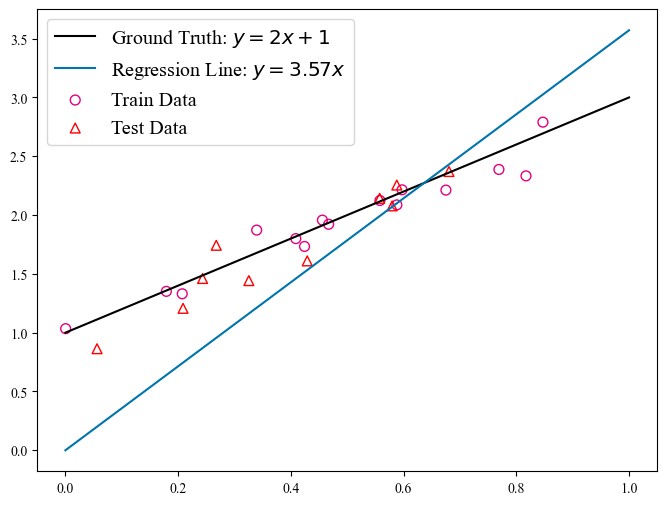

In [8]:
# Plot the regression line
y_pred = X_underlying * theta_closed_form
plt.plot(X_underlying.cpu(), y_underlying.cpu(), c='#000000', label=r"Ground Truth: $y = 2x + 1$")
plt.plot(X_underlying.cpu(), y_pred.cpu(), c='#0075ad', label=f"Regression Line: $y = {theta_closed_form:.2f}x$")
plt.scatter(X_train.cpu(), y_train.cpu(), facecolor="none", edgecolor='#e4007f', s=50, label="Train Data")
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker = '^', s=50, label="Test Data")
plt.legend(fontsize='x-large')
plt.show()

## Gradient Descent

Gradient descent is an optimization algorithm that is used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. The formula is as follows:

$$
\theta = \theta - \alpha \nabla_{\theta}\mathcal{L}(\theta)
$$

where $\theta$ is the parameter vector, $\alpha$ is the learning rate, and $\mathcal{L}(\theta)$ is the loss function.

Here we present an example of using the gradient descent algorithm to solve a $y = ax$-style linear regression problem without bias. The loss function is the mean squared error (MSE) function:

$$
\mathcal{L}(\theta) = \frac{1}{n}\sum_{i=1}^{n}(y_i - \theta x_i)^2
$$

where $n$ is the number of samples.

In [9]:
# Implement the Gradient Descent algorithm
def gradient_descent(X, y, learning_rate, n_epochs):
    """
    Implement the Gradient Descent algorithm
    """
    
    n_samples, n_features = X.shape
    theta = torch.zeros(n_features,1, device=device)
    
    for epoch in range(n_epochs):
        # calculate the gradient
        gradient = 2/n_samples * X.T @ (X @ theta - y)
        
        # update the parameter
        theta = theta - learning_rate * gradient
        
    return theta.item()

# Find the solution using the Gradient Descent algorithm
learning_rate = 0.1
n_epochs = 100
theta_gradient_descent = gradient_descent(X_train, y_train, learning_rate, n_epochs)
theta_gradient_descent

3.562868356704712

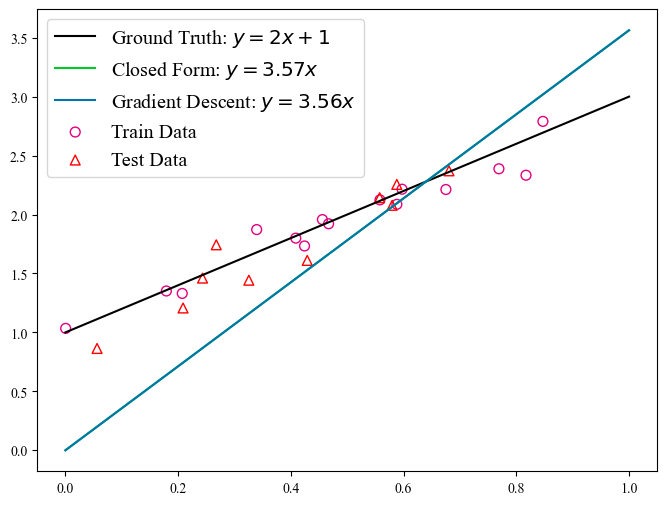

In [10]:
# Plot the regression line
y_pred = X_underlying * theta_gradient_descent
plt.plot(X_underlying.cpu(), y_underlying.cpu(), c='#000000', label=r"Ground Truth: $y = 2x + 1$")
plt.plot(X_underlying.cpu(), y_pred.cpu(), c='#00c92a', label=f"Closed Form: $y = {theta_closed_form:.2f}x$")
plt.plot(X_underlying.cpu(), y_pred.cpu(), c='#0075ad', label=f"Gradient Descent: $y = {theta_gradient_descent:.2f}x$")
plt.scatter(X_train.cpu(), y_train.cpu(), facecolor="none", edgecolor='#e4007f', s=50, label="Train Data")
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker = '^', s=50, label="Test Data")
plt.legend(fontsize='x-large')
plt.show()

# Questions

1. What metric does evaluate_rmse compute? How is it different from the standard deviation (std)? Explain in one sentence.

2. Read the parameter block at the top of data_generate.py. When D=3, W=[1.0, 0.5, -0.8], B=1, and NOISE_STD_TEST=2.0:
a) How many columns are in the generated train.txt and test_X.txt, respectively? What does the last column represent?
b) What is the approximate value of ||w||_2 for this setting?

3. When changing the model from “no bias” to “with bias,” what geometric change occurs to the regression line, and why does this usually reduce error?

# Answers

## 问题1：evaluate_rmse计算什么指标？与标准差(std)有何不同？

**回答：** `evaluate_rmse`计算的是均方根误差(RMSE)，它衡量的是预测值与真实值之间的平均偏差大小，而标准差衡量的是数据点相对于其均值的离散程度；RMSE关注预测准确性，标准差关注数据分布特征。

## 问题2：关于data_generate.py参数设置

**a) 当D=3, W=[1.0, 0.5, -0.8], B=1, NOISE_STD_TEST=2.0时：**
- `train.txt`有4列（3个特征列 + 1个标签列），最后一列代表目标变量y
- `test_X.txt`有3列（3个特征列），不包含标签

**b) ||w||_2的近似值：**
||w||_2 = √(1.0² + 0.5² + (-0.8)²) = √(1.0 + 0.25 + 0.64) = √1.89 ≈ 1.375

## 问题3：从"无偏置"到"有偏置"模型的几何变化

**回答：** 添加偏置项允许回归线在y轴上有截距，使模型能够拟合不通过原点的数据分布，这通常能显著减少误差，因为大多数真实数据并不满足y=ax的严格线性关系，而是更符合y=ax+b的形式。


# Exercise
Your task is to modify the provided code and implement both a closed-form solution and a gradient descent algorithm to solve the linear regression problem $y = ax + b$ with bias and polynomial linear regression. Concretely, you are required to:

1. Calculate the closed-form solution for the linear regression problem with bias. Implement the function `closed_form_solution_with_bias` to calculate the weight $\theta$ and bias $b$.

2. Calculate the gradient of the MSE loss function with respect to the weight and bias. Implement the function `gradient_descent_with_bias` to calculate the gradients and iteratively update the weight and bias using the gradient descent algorithm.

3. Extend the implementation to support multivariate linear regression when features are multi-dimensional.

4. Evaluate the performance of both the closed-form solution and the gradient descent algorithm on the test dataset. Implement the function evaluate to compute the RMSE of the predictions on the test data. Explain the meaning of the Root Mean Squared Error (RMSE) metric.

In [11]:
# 实现带偏置的线性回归函数

def closed_form_solution_with_bias(X, y):
    """
    计算带偏置的线性回归闭式解
    输入: X (N, D), y (N,)
    输出: theta (D+1,) 其中 theta[:-1] 是权重，theta[-1] 是偏置
    """
    N = X.shape[0]
    Phi = torch.cat([X, torch.ones(N, 1, device=X.device)], dim=1)
    
    theta = torch.inverse(Phi.T @ Phi) @ Phi.T @ y
    
    return theta

def gradient_descent_with_bias(X, y, learning_rate=0.01, n_epochs=1000):
    """
    使用梯度下降算法求解带偏置的线性回归
    输入: X (N, D), y (N,), learning_rate, n_epochs
    输出: theta (D+1,) 其中 theta[:-1] 是权重，theta[-1] 是偏置
    """
    N, D = X.shape
    # 初始化参数 [w, b]
    theta = torch.zeros(D + 1, 1, device=X.device, requires_grad=False)
    
    for epoch in range(n_epochs):
        # 构建设计矩阵
        Phi = torch.cat([X, torch.ones(N, 1, device=X.device)], dim=1)
        
        # 前向传播
        y_pred = Phi @ theta
        
        # 计算损失 (MSE)
        loss = torch.mean((y_pred - y.reshape(-1, 1)) ** 2)
        
        # 计算梯度
        grad = 2/N * Phi.T @ (Phi @ theta - y.reshape(-1, 1))
        
        # 更新参数
        theta = theta - learning_rate * grad
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    
    return theta

def evaluate_rmse(y_true, y_pred):
    """计算RMSE指标"""
    return torch.sqrt(torch.mean((y_pred - y_true) ** 2)).item()

def evaluate_performance(X_test, y_test, theta):
    """
    评估模型性能
    输入: X_test (N, D), y_test (N,), theta (D+1,)
    输出: RMSE值
    """
    N = X_test.shape[0]
    # 构建测试集设计矩阵
    Phi_test = torch.cat([X_test, torch.ones(N, 1, device=X_test.device)], dim=1)
    
    # 预测
    y_pred = Phi_test @ theta
    
    # 计算RMSE
    rmse = evaluate_rmse(y_test, y_pred.squeeze())
    
    return rmse, y_pred.squeeze()


=== 闭式解方法 ===
闭式解参数: w=1.817649245262146, b=1.0544

=== 梯度下降方法 ===
Epoch 0, Loss: 3.968580
Epoch 200, Loss: 0.051269
Epoch 400, Loss: 0.039236
Epoch 600, Loss: 0.030881
Epoch 800, Loss: 0.025004
梯度下降参数: w=1.3970903158187866, b=1.2695

=== 性能评估 ===
闭式解 RMSE: 0.585874
梯度下降 RMSE: 0.548037


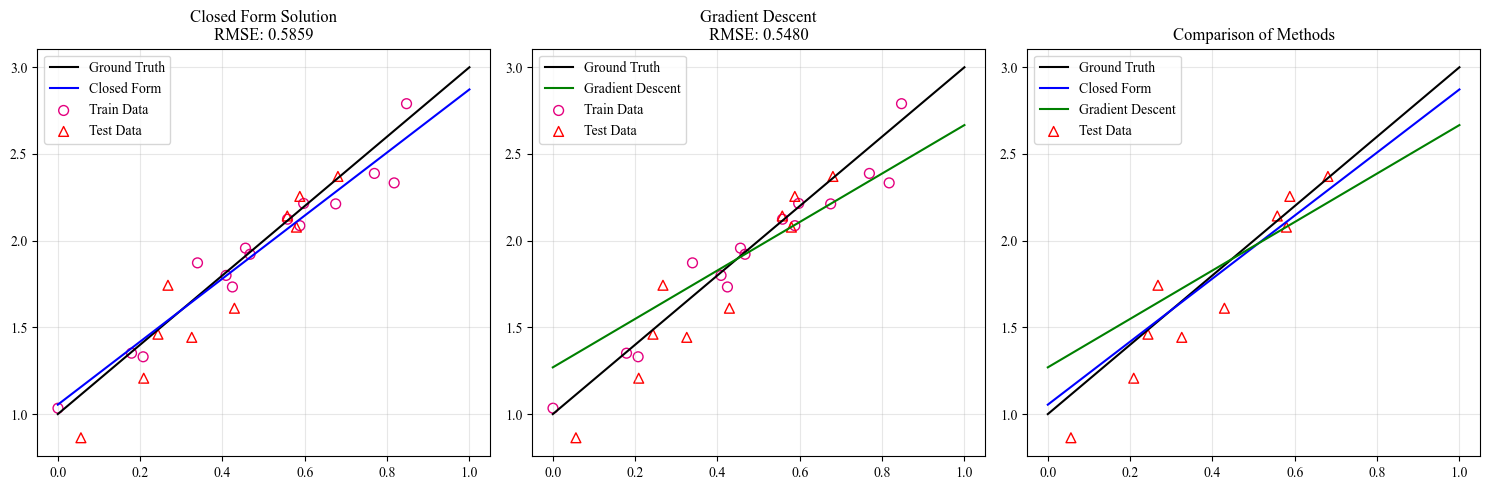

In [13]:
# 演示带偏置的线性回归

# 1. 使用闭式解
print("=== 闭式解方法 ===")
theta_closed = closed_form_solution_with_bias(X_train, y_train)
print(f"闭式解参数: w={theta_closed[:-1].squeeze().cpu().numpy()}, b={theta_closed[-1].item():.4f}")

# 2. 使用梯度下降
print("\n=== 梯度下降方法 ===")
theta_gd = gradient_descent_with_bias(X_train, y_train, learning_rate=0.01, n_epochs=1000)
print(f"梯度下降参数: w={theta_gd[:-1].squeeze().cpu().numpy()}, b={theta_gd[-1].item():.4f}")

# 3. 评估性能
print("\n=== 性能评估 ===")
rmse_closed, y_pred_closed = evaluate_performance(X_test, y_test, theta_closed)
rmse_gd, y_pred_gd = evaluate_performance(X_test, y_test, theta_gd)

print(f"闭式解 RMSE: {rmse_closed:.6f}")
print(f"梯度下降 RMSE: {rmse_gd:.6f}")

# 4. 可视化结果
plt.figure(figsize=(15, 5))

# 确保theta的形状正确
theta_closed_flat = theta_closed.squeeze()
theta_gd_flat = theta_gd.squeeze()

# 子图1: 闭式解结果
plt.subplot(1, 3, 1)
plt.plot(X_underlying.cpu(), y_underlying.cpu(), 'k-', label='Ground Truth')
plt.plot(X_underlying.cpu(), (X_underlying * theta_closed_flat[:-1] + theta_closed_flat[-1]).cpu(), 'b-', label='Closed Form')
plt.scatter(X_train.cpu(), y_train.cpu(), facecolor="none", edgecolor='#e4007f', s=50, label="Train Data")
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker='^', s=50, label="Test Data")
plt.title(f'Closed Form Solution\nRMSE: {rmse_closed:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2: 梯度下降结果
plt.subplot(1, 3, 2)
plt.plot(X_underlying.cpu(), y_underlying.cpu(), 'k-', label='Ground Truth')
plt.plot(X_underlying.cpu(), (X_underlying * theta_gd_flat[:-1] + theta_gd_flat[-1]).cpu(), 'g-', label='Gradient Descent')
plt.scatter(X_train.cpu(), y_train.cpu(), facecolor="none", edgecolor='#e4007f', s=50, label="Train Data")
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker='^', s=50, label="Test Data")
plt.title(f'Gradient Descent\nRMSE: {rmse_gd:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图3: 预测对比
plt.subplot(1, 3, 3)
plt.plot(X_underlying.cpu(), y_underlying.cpu(), 'k-', label='Ground Truth')
plt.plot(X_underlying.cpu(), (X_underlying * theta_closed_flat[:-1] + theta_closed_flat[-1]).cpu(), 'b-', label='Closed Form')
plt.plot(X_underlying.cpu(), (X_underlying * theta_gd_flat[:-1] + theta_gd_flat[-1]).cpu(), 'g-', label='Gradient Descent')
plt.scatter(X_test.cpu(), y_test.cpu(), facecolor="none", edgecolor="r", marker='^', s=50, label="Test Data")
plt.title('Comparison of Methods')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== 多变量线性回归 ===
真实参数: w=[2.  1.5], b=0.50
闭式解参数: w=[1.9584111 1.5216827], b=0.5048
Epoch 0, Loss: 6.746242
Epoch 200, Loss: 0.035050
Epoch 400, Loss: 0.033465
Epoch 600, Loss: 0.033465
Epoch 800, Loss: 0.033465
梯度下降参数: w=[1.9584146 1.521679 ], b=0.5048

多变量线性回归性能:
闭式解 RMSE: 0.232214
梯度下降 RMSE: 0.232214


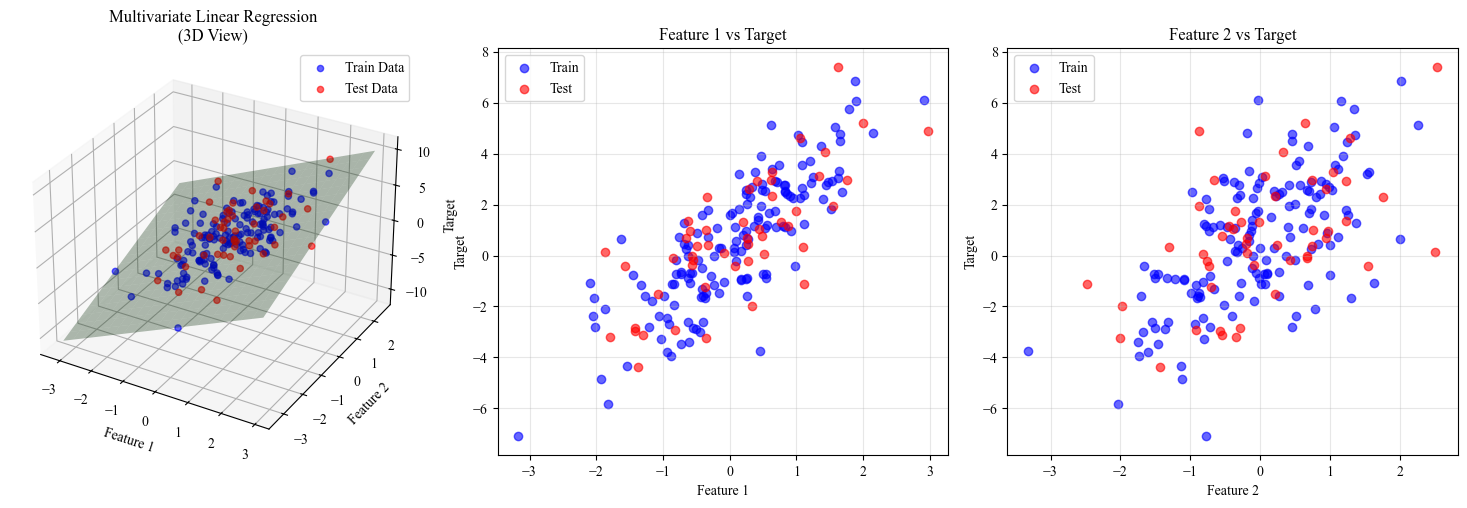

In [15]:
# 多变量线性回归演示

# 生成多变量数据
def create_multivariate_data(n_samples=100, n_features=2, noise=0.1):
    """生成多变量线性回归数据"""
    torch.manual_seed(42)
    X = torch.randn(n_samples, n_features, device=device)
    # 真实参数: y = 2*x1 + 1.5*x2 + 0.5
    true_w = torch.tensor([2.0, 1.5], device=device)
    true_b = 0.5
    y = X @ true_w + true_b + torch.randn(n_samples, device=device) * noise
    return X, y, true_w, true_b

# 生成数据
X_multi, y_multi, true_w, true_b = create_multivariate_data(n_samples=200, n_features=2, noise=0.2)
X_multi_train, X_multi_test = X_multi[:150], X_multi[150:]
y_multi_train, y_multi_test = y_multi[:150], y_multi[150:]

print("=== 多变量线性回归 ===")
print(f"真实参数: w={true_w.cpu().numpy()}, b={true_b:.2f}")

# 使用闭式解
theta_multi_closed = closed_form_solution_with_bias(X_multi_train, y_multi_train)
print(f"闭式解参数: w={theta_multi_closed[:-1].squeeze().cpu().numpy()}, b={theta_multi_closed[-1].squeeze().item():.4f}")

# 使用梯度下降
theta_multi_gd = gradient_descent_with_bias(X_multi_train, y_multi_train, learning_rate=0.01, n_epochs=1000)
print(f"梯度下降参数: w={theta_multi_gd[:-1].squeeze().cpu().numpy()}, b={theta_multi_gd[-1].squeeze().item():.4f}")

# 评估性能
rmse_multi_closed, _ = evaluate_performance(X_multi_test, y_multi_test, theta_multi_closed)
rmse_multi_gd, _ = evaluate_performance(X_multi_test, y_multi_test, theta_multi_gd)

print(f"\n多变量线性回归性能:")
print(f"闭式解 RMSE: {rmse_multi_closed:.6f}")
print(f"梯度下降 RMSE: {rmse_multi_gd:.6f}")

# 可视化多变量结果
fig = plt.figure(figsize=(15, 5))

# 3D散点图显示多变量回归
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_multi_train[:, 0].cpu(), X_multi_train[:, 1].cpu(), y_multi_train.cpu(), 
           c='blue', alpha=0.6, label='Train Data')
ax1.scatter(X_multi_test[:, 0].cpu(), X_multi_test[:, 1].cpu(), y_multi_test.cpu(), 
           c='red', alpha=0.6, label='Test Data')

# 创建网格用于显示回归平面
x1_range = torch.linspace(X_multi[:, 0].min(), X_multi[:, 0].max(), 20, device=device)
x2_range = torch.linspace(X_multi[:, 1].min(), X_multi[:, 1].max(), 20, device=device)
X1, X2 = torch.meshgrid(x1_range, x2_range, indexing='ij')
X_grid = torch.stack([X1.flatten(), X2.flatten()], dim=1)
theta_multi_closed_flat = theta_multi_closed.squeeze()
y_grid = X_grid @ theta_multi_closed_flat[:-1] + theta_multi_closed_flat[-1]
Y_grid = y_grid.reshape(X1.shape)

ax1.plot_surface(X1.cpu(), X2.cpu(), Y_grid.cpu(), alpha=0.3, color='green')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Target')
ax1.set_title('Multivariate Linear Regression\n(3D View)')
ax1.legend()

# 特征1 vs 目标值
ax2 = fig.add_subplot(132)
ax2.scatter(X_multi_train[:, 0].cpu(), y_multi_train.cpu(), c='blue', alpha=0.6, label='Train')
ax2.scatter(X_multi_test[:, 0].cpu(), y_multi_test.cpu(), c='red', alpha=0.6, label='Test')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Target')
ax2.set_title('Feature 1 vs Target')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 特征2 vs 目标值
ax3 = fig.add_subplot(133)
ax3.scatter(X_multi_train[:, 1].cpu(), y_multi_train.cpu(), c='blue', alpha=0.6, label='Train')
ax3.scatter(X_multi_test[:, 1].cpu(), y_multi_test.cpu(), c='red', alpha=0.6, label='Test')
ax3.set_xlabel('Feature 2')
ax3.set_ylabel('Target')
ax3.set_title('Feature 2 vs Target')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 总结与RMSE指标解释

### 实现总结


1. **带偏置的闭式解** (`closed_form_solution_with_bias`): 使用正规方程直接求解最优参数
2. **带偏置的梯度下降** (`gradient_descent_with_bias`): 通过迭代优化求解参数
3. **多变量线性回归**: 扩展到多维特征空间
4. **性能评估**: 使用RMSE指标评估模型性能

### RMSE (Root Mean Squared Error) 指标解释

**RMSE** 是回归问题中最常用的评估指标之一：

- **定义**: RMSE = √(Σ(y_pred - y_true)² / n)
- **含义**: 衡量预测值与真实值之间的平均偏差大小
- **单位**: 与目标变量y的单位相同
- **特点**: 
  - 对大误差更敏感（因为平方项）
  - 总是非负值
  - 越小表示模型性能越好
  - 直观易懂，便于解释

**与其他指标的比较**:
- **MAE (Mean Absolute Error)**: 对异常值不敏感，但RMSE对大误差惩罚更重
- **R² (决定系数)**: 衡量模型解释方差的比例，范围[0,1]
- **MSE**: RMSE的平方，单位是目标变量的平方

### 方法对比

| 方法 | 优点 | 缺点 | 适用场景 |
|------|------|------|----------|
| 闭式解 | 精确解，计算快 | 需要矩阵可逆，内存需求大 | 小到中等数据集 |
| 梯度下降 | 内存效率高，可处理大数据 | 需要调参，可能陷入局部最优 | 大数据集，在线学习 |

### Concluson

1. **偏置项的重要性**: 添加偏置项显著改善了模型拟合能力
2. **方法一致性**: 闭式解和梯度下降在收敛后应得到相同结果
3. **多变量扩展**: 线性回归自然扩展到多维特征空间
4. **可视化价值**: 图形化展示有助于理解模型行为
